In [ ]:
!pip install mip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.17.1
    Uninstalling cffi-1.17.1:
      Successfully uninstalled cffi-1.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pygit2 1.17.0 requires cffi>=1.17.0, but you have cffi 1.15.1 which is incompatible.


In [ ]:
from mip import Model, INTEGER, CONTINUOUS, xsum, minimize, OptimizationStatus
import pandas as pd
import numpy as np
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus
from google.colab import files
import io

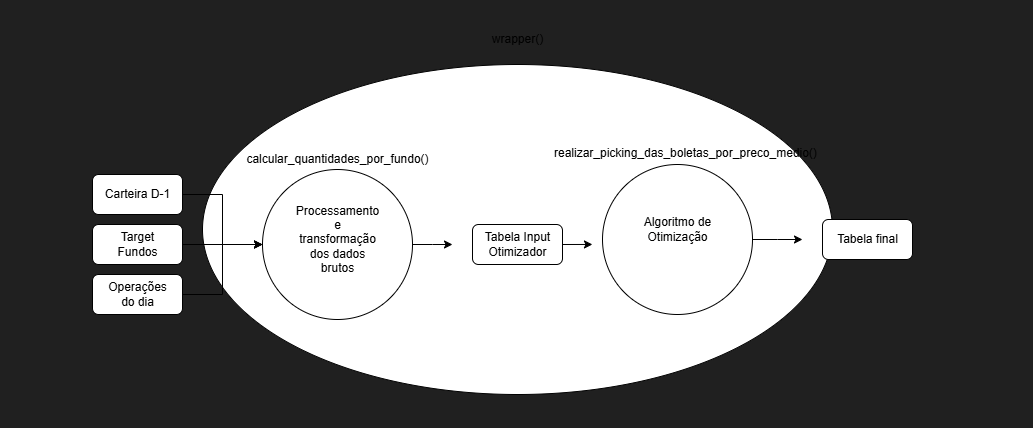

## Estrutura do Alocador
O alocador é dividido em três funções principais:


## `calcular_quantidades_por_fundo()`
Essa função é responsável por receber os dados brutos (carteira dos fundos referente ao dia anterior, proporção target dos fundos e as operações realizadas no dia, que somadas com a carteira do dia anterior, devem obedecer as proporções target) e agrega-los em uma única tabela com a quantidade target calculada para alimentar o otimizador.  


## `realizar_picking_das_boletas_por_preco_medio()`

Essa função é responsável por receber a tabela processada na função *calcular_quantidades_por_fundo()* e aplicar um algoritmo de otimização linear que tem como função objetivo **minimizar a soma dos desvios absolutos dos preços médios dos fundos em relação ao preço médio global**, mitigando assim uma possivel transfêrencia de riqueza entre fundos.


## `wrapper()`
Essa função é responsável por consolidar o calculo de quantidades e picking em apenas uma função, facilitando o uso do algoritmo e melhorando a legibilidade do fluxo de execução.


In [ ]:
def calcular_quantidades_por_fundo(df_carteira, df_boletasdia, df_target, df_restricaomultiplos):

  total_carteira_atualizado = df_carteira['Quantidade'].sum() + df_boletasdia['Quantidade'].sum()
  df_target['Quantidade_ideal'] = (df_target['Proporcao']*total_carteira_atualizado).round(0)


# Verificando se alguma boleta foi enviada com quantidades diferentes dos multiplos
  erros = []
  for i, ativo in enumerate(df_boletasdia['Ativo']):
      if ativo in df_restricaomultiplos:
          m = df_restricaomultiplos[ativo]
          if df_boletasdia['Quantidade'][i] % m != 0:
              erros.append(
                  f"Total disponível de '{ativo}' = {df_boletasdia['Quantidade'][i]} não é múltiplo de {m}"
              )
  if erros:
      raise ValueError("Erros de múltiplos na oferta:\n" + "\n".join(erros))

# Acrescentando o residuo no fundo com a maior quantidade em carteira
  fundo_maior_posicao = df_carteira.loc[df_carteira['Quantidade'].idxmax()]['Fundo']
  qtd_residuo = total_carteira_atualizado - df_target['Quantidade_ideal'].sum()
  df_target['Quantidade_ideal'] = np.where(df_target['Fundo'] == fundo_maior_posicao, df_target['Quantidade_ideal']+qtd_residuo,df_target['Quantidade_ideal'])

# Juntando a carteira e o target pra encontrar a diferença (O quanto deve ser alocado em cada)
  df_target = pd.merge(
    df_carteira,
    df_target,
    on=['Fundo'],
    how='inner'
)
  df_target['Diferença'] = df_target['Quantidade_ideal'] - df_target['Quantidade']
  df_target_final = otimizar_alocacao(df_target, df_boletasdia['Quantidade'].sum())

  return df_target



In [ ]:
def otimizar_alocacao(df_target, total_boletasdia):
    df = df_target.reset_index(drop=True).copy()
    num_funds = len(df)
    total_carteira = df['Quantidade'].sum()
    total_atualizado = total_carteira + total_boletasdia

    m = Model('Otimizador_Target')
    x = [m.add_var(lb=0, var_type=INTEGER) for _ in range(num_funds)]
    erro = [m.add_var(lb=0, var_type=CONTINUOUS) for _ in range(num_funds)]

    m += xsum(x[i] for i in range(num_funds)) == total_boletasdia

    for i in range(num_funds):
        prop_atual = (df.loc[i, 'Quantidade'] + x[i]) / total_atualizado
        m += erro[i] >= df.loc[i, 'Proporcao'] - prop_atual
        m += erro[i] >= prop_atual - df.loc[i, 'Proporcao']

    m.objective = minimize(xsum(erro[i] for i in range(num_funds)))
    m.optimize()

    allocated = [int(x[i].x) for i in range(num_funds)]
    df['Allocated'] = allocated
    df['Quantidade_ideal'] = df['Quantidade'] + df['Allocated']
    df['Diferença'] = df['Quantidade_ideal'] - df['Quantidade']

    return df[['Fundo', 'Quantidade', 'Proporcao', 'Allocated', 'Quantidade_ideal', 'Diferença']]


In [ ]:
def realizar_picking_das_boletas_por_preco_medio(df_boletasdia, df_target):

  prices = df_boletasdia['Preco']
  n = df_boletasdia['Quantidade']   # número de operações para cada preço

  # Capacidade de cada fundo
  funds = df_target['Diferença']

  # Cálculo do preço médio global:
  total_operations = sum(n)
  total_price = sum(n[i] * prices[i] for i in range(len(prices)))
  P_global = total_price / total_operations
  #print("Preço médio global:", P_global.round(4))

  # Criação do modelo
  m = Model()

  num_prices = len(prices)
  num_funds = len(funds)

  # Variáveis de decisão: x[i][j] = número de operações de preço prices[i] alocadas no fundo j
  x = [[m.add_var(var_type=CONTINUOUS, lb=0) for j in range(num_funds)] for i in range(num_prices)]

  # Variáveis auxiliares para representar o desvio absoluto em cada fundo
  t = [m.add_var(var_type=CONTINUOUS, lb=0) for _ in range(num_funds)]

  # Restrição 1: Cada preço deve ser totalmente alocado entre os fundos
  for i in range(num_prices):
      m.add_constr(xsum(x[i][j] for j in range(num_funds)) == n[i])

  # Restrição 2: A soma das operações alocadas em cada fundo deve ser igual ao seu target
  for j in range(num_funds):
      m.add_constr(xsum(x[i][j] for i in range(num_prices)) == funds[j])

  # Restrição 3: Linearização do desvio absoluto
  for j in range(num_funds):
      expr = xsum(prices[i] * x[i][j] for i in range(num_prices))
      m.add_constr(t[j] >= expr - P_global * funds[j])
      m.add_constr(t[j] >= - (expr - P_global * funds[j]))

  # Restrição 4: Alocações com multiplos 
    # for i, ativo in enumerate(ativos_i):
    # if ativo in multiplo_dict:
    #     m_val = multiplo_dict[ativo]
    #     for j in range(num_funds):
    #         z[(i,j)] = m.add_var(var_type=INTEGER, lb=0, name=f"z_{i}_{j}")
    #         m.add_constr(x[i][j] == z[(i,j)] * m_val)
    

  # Função objetivo: minimizar a soma dos desvios absolutos
  m.objective = minimize(xsum(t[j] for j in range(num_funds)))

  # Otimiza o modelo
  m.optimize()

  # -------------------------------------------------
  # Construindo um DataFrame com os resultados
  # -------------------------------------------------
  if m.status == OptimizationStatus.OPTIMAL:
      rows = []

      for j in range(num_funds):
          fundo_nome = df_target.iloc[j]['Fundo']

          # Calcula o valor total alocado no fundo j, para depois calcular o preço médio
          total_valor = 0
          for i in range(num_prices):
              # Número de operações alocadas (arredondando, se for o caso)
              aloc = round(x[i][j].x)
              total_valor += prices[i] * aloc

          # Preço médio e desvio absoluto do fundo j
          avg_fundo = total_valor / funds[j]
          dev_abs = t[j].x

          for i in range(num_prices):
              aloc = round(x[i][j].x)
              rows.append({
                  'Fundo': fundo_nome,
                  'Preco': prices[i],
                  'Operacoes': aloc,
                  'PrecoMedioFundo': avg_fundo,
                  'DesvioAbsoluto': dev_abs
              })

      df_result = pd.DataFrame(rows)

  else:
      print("Solução ótima não encontrada.")
      df_result = pd.DataFrame()

  return df_result

In [ ]:
# def wrapper(df_carteira, df_boletasdia, df_target):

#   target = calcular_quantidades_por_fundo(df_carteira, df_boletasdia, df_target)
#   resultado = realizar_picking_das_boletas_por_preco_medio(df_boletasdia, target)

#   return resultado

In [ ]:
import pandas as pd
from typing import List, Set

def wrapper(
    df_carteira: pd.DataFrame,
    df_boletasdia: pd.DataFrame,
    df_target: pd.DataFrame,
    input_restricaomultiplos: pd.DataFrame,
) -> pd.DataFrame:

    carteiras_grouped = df_carteira.groupby('Ticker', sort=False)
    boletas_grouped = df_boletasdia.groupby('Ticker', sort=False)
    target_grouped = df_target.groupby('Ticker', sort=False)

    tickers_in_carteira: Set[str] = set(carteiras_grouped.groups.keys())
    tickers_in_boletas: Set[str] = set(boletas_grouped.groups.keys())
    tickers_in_target: Set[str] = set(target_grouped.groups.keys())
    common_tickers: Set[str] = tickers_in_carteira & tickers_in_boletas & tickers_in_target

    resultados: List[pd.DataFrame] = []

    for ticker in common_tickers:
        df_cart = carteiras_grouped.get_group(ticker)
        df_boletas = boletas_grouped.get_group(ticker)
        df_tgt = target_grouped.get_group(ticker)

        target_df = calcular_quantidades_por_fundo(df_cart, df_boletas, df_tgt, input_restricaomultiplos)

        result_df = realizar_picking_das_boletas_por_preco_medio(df_boletas, target_df)

        result_df = result_df.copy()
        result_df['Ticker'] = ticker
        resultados.append(result_df)

    if resultados:
        return pd.concat(resultados, ignore_index=True)
    else:
        empty_cols = ['Fundo', 'Quantidade', 'Proporcao', 'Allocated', 'Quantidade_ideal', 'Diferença', 'Ticker']
        return pd.DataFrame(columns=empty_cols)


In [ ]:
def main():

  csv_arquivos = files.upload()
  input_target = pd.read_excel(io.BytesIO(csv_arquivos['proporcao.xlsx']))
  input_carteira = pd.read_excel(io.BytesIO(csv_arquivos['carteira.xlsx']))
  input_boletasdia = pd.read_excel(io.BytesIO(csv_arquivos['boletasdia.xlsx']))
  input_restricaomultiplos = pd.read_excel(io.BytesIO(csv_arquivos['restricaomultiplo.xlsx']))

  print(wrapper(input_carteira, input_boletasdia, input_target, input_restricaomultiplos))

In [ ]:
if __name__ == "__main__":
    main()

Saving boletasdia.xlsx to boletasdia.xlsx
Saving proporcao.xlsx to proporcao.xlsx
Saving carteira.xlsx to carteira.xlsx
     Fundo  Preco  Operacoes  PrecoMedioFundo  DesvioAbsoluto
0  Fundo A     10          7        10.416667             0.0
1  Fundo A     11          5        10.416667             0.0
2  Fundo A      9          0        10.416667             0.0
3  Fundo B     10          1        10.000000             0.0
4  Fundo B     11          0        10.000000             0.0
5  Fundo B      9          0        10.000000             0.0
6  Fundo C     10          4        10.454545             0.0
7  Fundo C     11         14        10.454545             0.0
8  Fundo C      9          4        10.454545             0.0
